# XGBoost Baseline - LB 0.678
In this notebook we present a XGBoost baseline. We train GroupKFold models for each of the 18 questions. Our CV score is 0.678. We infer test using one of our KFold models. We can improve our CV and LB by engineering more features for our xgboost and/or trying different models (like other ML models and/or RNN and/or Transformer). Also we can improve our LB by using more KFold models OR training one model using all data (and the hyperparameters that we found from our KFold cross validation).

**UPDATE** On March 20 2023, Kaggle doubled the size of train data. Therefore we updated this notebook to avoid memory error. We accomplish this by reading train data in chunks and feature engineering in chunks. Note that another way to avoid memory error is to use two notebooks. Train models in one notebook that has 32GB RAM (and save models), and then submit the required 8GB RAM notebook (with loaded models) as a second notebook. (Discussion [here][1]).

[1]: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/386218

In [1]:
import pandas as pd, numpy as np, gc
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Load Train Data and Labels
On March 20 2023, Kaggle doubled the size of train data (discussion [here][1]). The train data is now 4.7GB! To avoid memory error, we will read the train data in as 10 pieces and feature engineer each piece before reading the next piece. This works because feature engineering shrinks the size of each piece.

[1]: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/396202

In [2]:
# READ USER ID ONLY
tmp = pd.read_csv("/home/dcai/kaggle/predict-student-performance-from-game-play/train.csv",usecols=[0])
tmp = tmp.groupby('session_id').session_id.agg('count')

# COMPUTE READS AND SKIPS
PIECES = 10
CHUNK = int( np.ceil(len(tmp)/PIECES) )

reads = []
skips = [0]
for k in range(PIECES):
    a = k*CHUNK
    b = (k+1)*CHUNK
    if b>len(tmp): b=len(tmp)
    r = tmp.iloc[a:b].sum()
    reads.append(r)
    skips.append(skips[-1]+r)
    
print(f'To avoid memory error, we will read train in {PIECES} pieces of sizes:')
print(reads)

To avoid memory error, we will read train in 10 pieces of sizes:
[1344818, 1309338, 1327256, 1311918, 1315803, 1325520, 1318382, 1302883, 1316753, 1301540]


In [3]:
train = pd.read_csv('/home/dcai/kaggle/predict-student-performance-from-game-play/train.csv', nrows=reads[0])
print('Train size of first piece:', train.shape )
train.head()

Train size of first piece: (1344818, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [4]:
targets = pd.read_csv('/home/dcai/kaggle/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(212022, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


# Feature Engineer
We create basic aggregate features. Try creating more features to boost CV and LB! The idea for EVENTS feature is from [here][1]

[1]: https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data

In [5]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

# https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   level   int64
dtypes: int64(1)
memory usage: 100.5 MB
None
level    0
dtype: int64


111

In [31]:
def feature_engineer(train):
    
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    
    

    
    train = train.drop(EVENTS,axis=1)
        
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [32]:
%%time

# PROCESS TRAIN DATA IN PIECES
all_pieces = []
print(f'Processing train as {PIECES} pieces to avoid memory error... ')
for k in range(PIECES):
    print(k,', ',end='')
    SKIPS = 0
    if k>0: SKIPS = range(1,skips[k]+1)
    train = pd.read_csv('/home/dcai/kaggle/predict-student-performance-from-game-play/train.csv',
                        nrows=reads[k], skiprows=SKIPS)
    df = feature_engineer(train)
    all_pieces.append(df)
    
# CONCATENATE ALL PIECES
print('\n')
del train; gc.collect()
df = pd.concat(all_pieces, axis=0)
print('Shape of all train data after feature engineering:', df.shape )
df.head()

Processing train as 10 pieces to avoid memory error... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 

Shape of all train data after feature engineering: (35337, 31)
CPU times: user 41.4 s, sys: 1.44 s, total: 42.8 s
Wall time: 42.8 s


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,-1.0,7.701275,-71.413749,...,81,22,28,11,4,8,2,4,1,14155937
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,-1.0,-130.347170,-162.004310,...,170,123,60,20,14,10,6,3,1,437052322
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,-1.0,14.306062,-57.269322,...,103,104,12,28,9,9,8,1,1,105732736
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,0.0,-84.045960,-53.671082,...,49,18,36,15,3,5,3,2,1,13571045
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,5.1,-30.762282,-142.861892,...,637,145,65,83,186,14,45,5,1,3241011333


In [30]:
df.columns.values

array(['level_group', 'event_name_nunique', 'fqid_nunique',
       'room_fqid_nunique', 'text_nunique', 'elapsed_time_mean',
       'level_mean', 'page_mean', 'room_coor_x_mean', 'room_coor_y_mean',
       'screen_coor_x_mean', 'screen_coor_y_mean', 'hover_duration_mean',
       'elapsed_time_std', 'level_std', 'page_std', 'room_coor_x_std',
       'room_coor_y_std', 'screen_coor_x_std', 'screen_coor_y_std',
       'hover_duration_std', 'navigate_click_sum', 'person_click_sum',
       'cutscene_click_sum', 'object_click_sum', 'map_hover_sum',
       'notification_click_sum', 'map_click_sum', 'observation_click_sum',
       'checkpoint_sum', 'elapsed_time_sum'], dtype=object)

In [33]:
NUMS2=['event_name_nunique', 'fqid_nunique',
       'room_fqid_nunique', 'text_nunique', 'elapsed_time_mean',
       'level_mean', 'page_mean', 'room_coor_x_mean', 'room_coor_y_mean',
       'screen_coor_x_mean', 'screen_coor_y_mean', 'hover_duration_mean',
       'elapsed_time_std', 'level_std', 'page_std', 'room_coor_x_std',
       'room_coor_y_std', 'screen_coor_x_std', 'screen_coor_y_std',
       'hover_duration_std', 'navigate_click_sum', 'person_click_sum',
       'cutscene_click_sum', 'object_click_sum', 'map_hover_sum',
       'notification_click_sum', 'map_click_sum', 'observation_click_sum',
       'checkpoint_sum', 'elapsed_time_sum']
km = KMeans(random_state=0)
pca = PCA(n_components=len(NUMS2), random_state=0)

pca.fit(df[NUMS2])

fa = FactorAnalysis(n_components=len(NUMS2), max_iter=100, rotation='varimax', random_state=1)
fa.fit(df[NUMS2])

del km; gc.collect()

0

In [35]:
    
extra_feats = [f'fa_{i}'for i in range(len(NUMS2))]
df[extra_feats] = fa.transform(df[NUMS2])


pca.fit(df[NUMS2])
pca_feats = [f'pca_{i}'for i in range(len(NUMS2))]
df[pca_feats] = pca.transform(df[NUMS2])

In [36]:
df.head()

,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,...,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,-1.0,7.701275,-71.413749,...,2.210541,-1.854765,1.036708,1.639752,0.889666,-0.030901,-0.471277,0.211577,-0.141478,-0.001070
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,-1.0,-130.347170,-162.004310,...,-1.293753,0.998645,2.808256,-1.574530,-0.822655,0.250971,0.703321,-0.275954,-0.050058,-0.041127
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,-1.0,14.306062,-57.269322,...,0.458865,0.762691,0.938822,-1.793943,-0.830066,-0.058165,0.105521,0.304142,0.025957,0.004276
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,0.0,-84.045960,-53.671082,...,0.579874,-2.428541,-0.446942,0.757850,-0.245531,0.440389,0.605785,0.035397,0.003428,-0.020804
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,5.1,-30.762282,-142.861892,...,0.086231,0.747619,0.484115,-2.584973,0.911323,1.152210,-2.116067,-0.401634,-0.474286,-0.000639


# Train XGBoost Model
We train one model for each of 18 questions. Furthermore, we use data from `level_groups = '0-4'` to train model for questions 1-3, and `level groups '5-12'` to train questions 4 thru 13 and `level groups '13-22'` to train questions 14 thru 18. Because this is the data we get (to predict corresponding questions) from Kaggle's inference API during test inference. We can improve our model by saving a user's previous data from earlier `level_groups` and using that to predict future `level_groups`.

In [37]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 90 features
We will train with 11779 users info


In [38]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################


/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1(125), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2(133), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3(91), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4(120), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5(66), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6(123), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7(126), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


8(63), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9(73), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


10(129), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


11(95), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


12(78), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


13(84), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


14(97), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


15(116), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


16(68), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


17(84), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


18(138), 
#########################
### Fold 2
#########################


/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1(146), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2(116), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3(104), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4(125), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5(78), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6(107), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7(108), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


8(50), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9(85), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


10(71), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


11(47), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


12(94), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


13(67), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


14(90), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


15(83), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


16(63), 17(33), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


18(85), 
#########################
### Fold 3
#########################


/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1(61), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2(113), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3(88), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4(100), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5(70), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6(55), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7(117), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


8(63), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9(148), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


10(115), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


11(92), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


12(76), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


13(81), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


14(132), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


15(108), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


16(98), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


17(45), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


18(117), 
#########################
### Fold 4
#########################


/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1(136), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2(101), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3(95), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4(116), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5(175), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6(111), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7(71), 8(40), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9(79), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


10(113), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


11(60), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


12(91), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


13(57), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


14(80), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


15(126), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


16(52), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


17(68), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


18(131), 
#########################
### Fold 5
#########################


/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


1(141), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2(101), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


3(90), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


4(126), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


5(86), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


6(96), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


7(71), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


8(48), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


9(133), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


10(116), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


11(50), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


12(93), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


13(122), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


14(101), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


15(158), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


16(63), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


17(88), 

/home/dcai/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


18(80), 


# Compute CV Score
We need to convert prediction probabilities into `1s` and `0s`. The competition metric is F1 Score which is the harmonic mean of precision and recall. Let's find the optimal threshold for `p > threshold` when to predict `1` and when to predict `0` to maximize F1 Score.

In [39]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [40]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

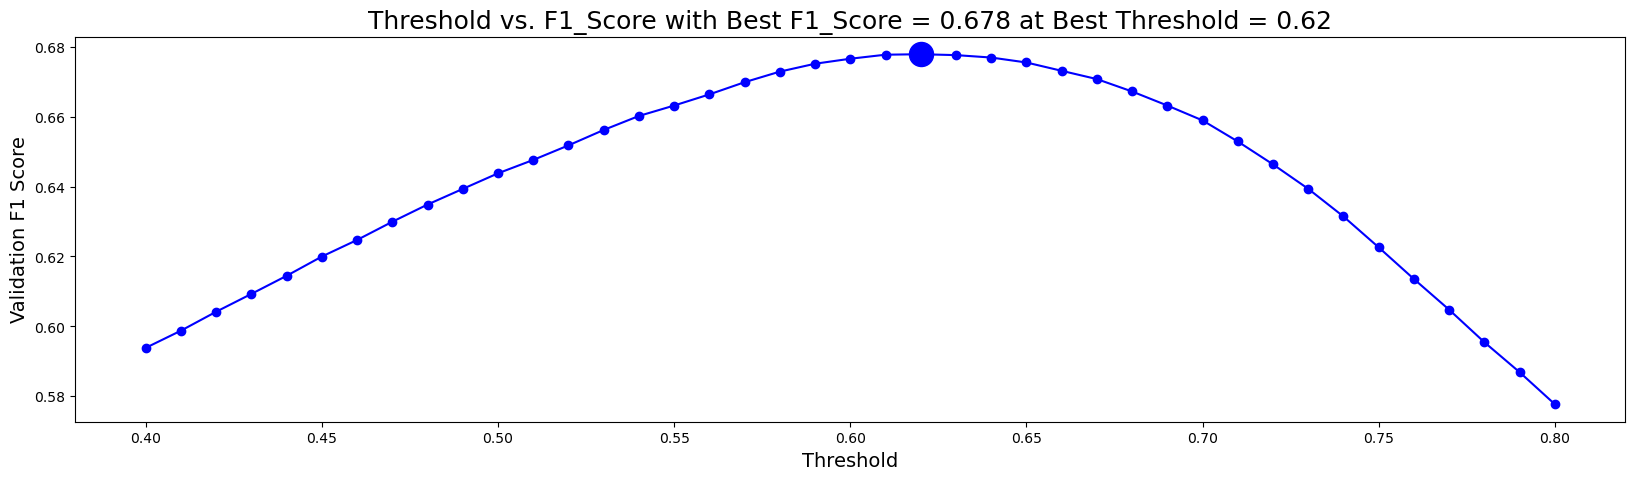

In [41]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [42]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5895127400645788
Q1: F1 = 0.49457198026174637
Q2: F1 = 0.48977180824786926
Q3: F1 = 0.6175342457840909
Q4: F1 = 0.5812669553703487
Q5: F1 = 0.6062841149962845
Q6: F1 = 0.592109857198097
Q7: F1 = 0.536912878003035
Q8: F1 = 0.5998849116297411
Q9: F1 = 0.5198417234736581
Q10: F1 = 0.5959742961780412
Q11: F1 = 0.4962375141261704
Q12: F1 = 0.43399463933513455
Q13: F1 = 0.6019833455809104
Q14: F1 = 0.5152816263162922
Q15: F1 = 0.4546196120290257
Q16: F1 = 0.5377529404177712
Q17: F1 = 0.4886428841072102
==> Overall F1 = 0.6778478945168616


# Infer Test Data

In [14]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

# CLEAR MEMORY
import gc
del targets, df, oof, true
_ = gc.collect()

ModuleNotFoundError: No module named 'jo_wilder'

In [ ]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    
    # FEATURE ENGINEER TEST DATA
    df = feature_engineer(test)
    
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[0,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int( p > best_threshold )
    
    env.predict(sample_submission)

# EDA submission.csv

In [ ]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

In [ ]:
print(df.correct.mean())